In [24]:
import constants as co
from analyzers import analyze_classifier, analyze_regressor, get_model_predictions
from auxiliary import loggers

from rdkit import Chem

from pathlib import Path
import sys

import pandas as pd
pd.options.display.max_rows = 5000
pd.set_option("display.max_colwidth", 200)
import numpy as np
import os

import pickle
import json
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

l = loggers.get_logger(logger_name="logger")

METHOD_PREFIX = "rf"
RESULT_FILE_REGRESSOR = "result_regressor_rf.csv"
RESULT_FILE_CLASSIFIER = "result_classifier_rf.csv"

DATA_DIR = Path("../data")

In [2]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2023-03-02 23:39:02,050 - logger - INFO - rorgammaqsar


In [3]:
candidate_file = Path(DATA_DIR/"candidates"/"20230131-L3900-Preclinical-Clinical-Compound-Library_cleaned.SDF")
mols = list(Chem.SDMolSupplier(candidate_file.as_posix()))

[23:39:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[23:39:08] ERROR: Could not sanitize molecule ending on line 14047
[23:39:08] ERROR: Explicit valence for atom # 8 N, 4, is greater than permitted
[23:39:09] Warning: conflicting stereochemistry at atom 3 ignored. by rule 2a.
[23:39:09] Warning: conflicting stereochemistry at atom 31 ignored. by rule 2b.
[23:39:09] Explicit valence for atom # 0 N, 4, is greater than permitted
[23:39:09] ERROR: Could not sanitize molecule ending on line 246280
[23:39:09] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
[23:39:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:39:09] ERROR: Could not sanitize molecule ending on line 255995
[23:39:09] ERROR: Explicit valence for atom # 2 N, 4, is greater than permitted
[23:39:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[23:39:09] ERROR: Could not sanitize molecule ending on line 292152
[23:39:09] ERROR: Explicit valence for

In [8]:
len(external_smiles)

3395

In [9]:
len(names)

3395

In [11]:
external_smiles = []
names = []
for mol in mols:
    try:
        sms = Chem.MolToSmiles(mol)
        props = mol.GetPropsAsDict()
        name = props["Name"]
        external_smiles.append(sms)
        names.append(name)
    except KeyError:
        pass
    except Exception as e:
        print(e)
        
external_smiles = pd.DataFrame({"external_smiles": external_smiles, "names": names})

Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)
'utf-8' codec can't decode byte 0xa6 in position 18: invalid start byte
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)
Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=Fals

In [12]:
external_smiles

,external_smiles,names
0,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(Cc4ccccc4-c4ccc(Cl)cc4)CC3)cc2)cc1[N+](=O)[O-],ABT-737
1,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)cc2)c1,Linifanib (ABT-869)
2,C[C@]1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,ABT-888 (Veliparib)
3,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,Axitinib
4,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO5)ncnc3c2)CC1,Saracatinib (AZD0530)
...,...,...
3390,CS(=O)(=O)N1CCC(NC(=O)c2n[nH]cc2NC(=O)c2c(Cl)cccc2Cl)CC1,NVP-LCQ195
3391,O=C1N=C(Nc2c(Cl)cccc2Cl)S/C1=C\c1ccc2nccnc2c1,GSK626616
3392,N=C(N)NCCC(=O)O,RGX-202
3393,COc1ccc(-c2c(Nc3ccccn3)[nH]c3c(C4=CCCCC4)c(-c4ccccc4)nn3c2=O)cc1,AG-270


In [14]:
X_val, y_train_val, y_train_val_pred, X_train, y_train, y_train_pred, X_ext, y_reg = get_model_predictions(co.TRAINING_CONF_DIR/"median_100"/"svm_regression_Morgan_1024_pca_128_QED.json", smiles_codes_ext=external_smiles["external_smiles"])
y_reg.name = "pred_reg"
y_reg.head()

2023-03-02 23:42:43,032 - logger - INFO - Scaler constructor...
2023-03-02 23:42:43,032 - logger - INFO - PCA constructor...
2023-03-02 23:42:43,038 - logger - INFO - Scaler constructor...
2023-03-02 23:42:43,039 - logger - INFO - PCA constructor...
2023-03-02 23:42:43,039 - logger - INFO - Optimal hyperparameters:, {'C': 2.4825430099517085, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'epsilon': 0.1311194468831029, 'shrinking': False, 'tol': 0.001, 'verbose': False}
2023-03-02 23:42:43,040 - logger - INFO - CreateFPS fit...
2023-03-02 23:42:43,040 - logger - INFO - CreateFPS transform...
100%|██████████| 2005/2005 [00:04<00:00, 415.86it/s]
2023-03-02 23:42:51,317 - logger - INFO - Scaler fit...
2023-03-02 23:42:51,324 - logger - INFO - Scaler transform...
2023-03-02 23:42:51,334 - logger - INFO - Scaler fit...
2023-03-02 23:42:51,544 - logger - INFO - CreateFPS fit...
2023-03-02 23:42:51,544 - logger - INFO - CreateFPS transform...
1

0    6.436377
1    4.616777
2    4.273401
3    4.212092
4    5.170238
Name: pred_reg, dtype: float64

Text(0.5, 1.0, 'Distribution of pIC50 values')

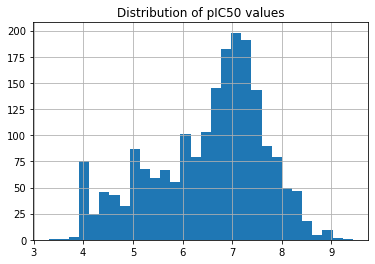

In [15]:
y_train.hist(bins=30)
plt.title("Distribution of pIC50 values")

In [16]:
X_val, y_train_val, y_train_val_pred, X_train, y_train, y_train_pred, X_ext, y_cla = get_model_predictions(co.TRAINING_CONF_DIR/"median_100"/"xgboost_classification_Morgan_1024.json", smiles_codes_ext=external_smiles["external_smiles"])
y_cla.name = "pred_cla"
y_cla.head()

2023-03-02 23:43:32,373 - logger - INFO - Optimal hyperparameters:, {'n_estimators': 207, 'max_depth': 11, 'min_child_weight': 4.0, 'eta': 0.0981512863074986, 'subsample': 0.8489134735056307, 'colsample_bytree': 0.9991597152608629, 'gamma': 0.09722750628904986, 'reg_alpha': 0.43598619904511926, 'reg_lambda': 0.9494079510404132, 'objective': 'reg:logistic'}
2023-03-02 23:43:32,374 - logger - INFO - CreateFPS fit...
2023-03-02 23:43:32,374 - logger - INFO - CreateFPS fit...
2023-03-02 23:43:32,375 - logger - INFO - CreateFPS transform...
2023-03-02 23:43:32,888 - logger - INFO - CreateFPS fit...
2023-03-02 23:43:32,889 - logger - INFO - CreateFPS transform...
2023-03-02 23:43:34,005 - logger - INFO - CreateFPS fit...
2023-03-02 23:43:34,005 - logger - INFO - CreateFPS transform...


0    0.710623
1    0.019010
2    0.038438
3    0.012845
4    0.276346
Name: pred_cla, dtype: float32

Text(0.5, 1.0, 'Distribution of binarized values')

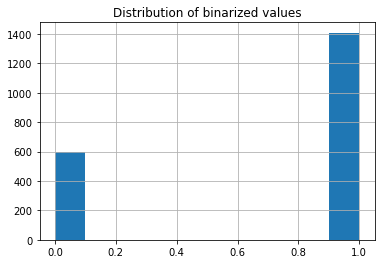

In [17]:
y_train.astype(int).hist()
plt.title("Distribution of binarized values")

In [18]:
external_data_with_preds = pd.concat([external_smiles, y_cla, y_reg], axis=1)
external_data_with_preds["pred_reg_IC50"] = external_data_with_preds["pred_reg"].apply(lambda x: np.power(10, -x) * 10e9)
external_data_with_preds = external_data_with_preds.sort_values("pred_cla", ascending=False)

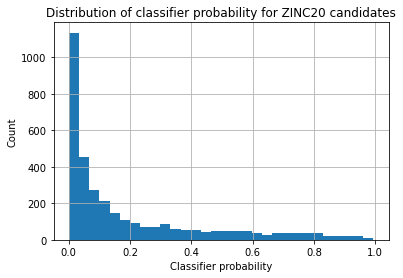

In [19]:
external_data_with_preds["pred_cla"].hist(bins=30)
plt.title("Distribution of classifier probability for ZINC20 candidates")
plt.xlabel("Classifier probability")
plt.ylabel("Count")
plt.savefig(fname="zinc20_classifier_distribution.pdf", format="pdf", dpi=200, bbox_inches='tight')

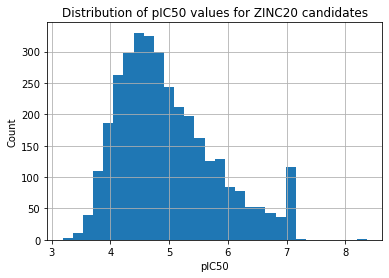

In [20]:
external_data_with_preds["pred_reg"].hist(bins=30)
plt.title("Distribution of pIC50 values for ZINC20 candidates")
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.savefig(fname="zinc20_regressor_distribution.pdf", format="pdf", dpi=200, bbox_inches='tight')


In [26]:
# external_data_with_preds

In [23]:
external_data_with_preds.to_csv(DATA_DIR/"candidates"/"20230131-L3900-Preclinical-Clinical-Compound-Library_preds.csv", index=False, sep="\t")

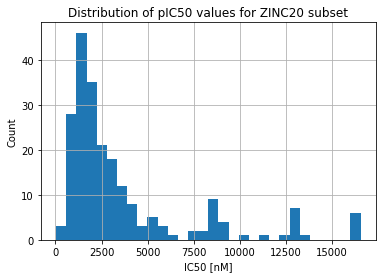

In [32]:
relevant_subset = external_data_with_preds[external_data_with_preds["pred_cla"] > 0.9]
relevant_subset[relevant_subset["pred_reg_IC50"]< 30000]["pred_reg_IC50"].hist(bins=30)
plt.title("Distribution of pIC50 values for ZINC20 subset")
plt.xlabel("IC50 [nM]")
plt.ylabel("Count")
plt.savefig(fname="zinc20_classifier_distribution_subset.pdf", format="pdf", dpi=200, bbox_inches='tight')

In [38]:
print(relevant_subset[relevant_subset["pred_reg_IC50"]< 5000]["pred_reg_IC50"].shape[0]/relevant_subset[relevant_subset["pred_reg_IC50"]< 30000]["pred_reg_IC50"].shape[0])

0.8018433179723502


In [34]:
print(relevant_subset[relevant_subset["pred_reg_IC50"]< 30000]["pred_reg_IC50"].min())
print(relevant_subset[relevant_subset["pred_reg_IC50"]< 30000]["pred_reg_IC50"].max())

36.682449290874565
16556.51976260363


In [ ]:
external_data_with_preds.sort_values("pred_reg_IC50")

In [ ]:
external_data_with_preds.sort_values("pred_reg_IC50")

In [ ]:
external_data_with_preds.to_csv(co.DATA_DIR_CANDIDATES/"search_space_ror_gamma_all_active_predictions_with_chembl.csv", index=False)